In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import tensornets as nets
import skimage.transform

## List of tasks:

1. Load images as arrays
2. Load labels
3. Convert labels from one-hot vector to vector of labels
4. Display images with labels
5. Flip images and labels
6. Make x and y training + dev arrays
7. Load pre-trained architecture (eg. VGG19)
8. Train with new data
9. Make predictions
10. Set up metrics - accuracy, precision, recall. Output train and dev metrics.
11. Tune hyperparameters

In [2]:
img_loc = '../ISIC2018_Task3_Training_Input/'
filelist = glob.glob(img_loc+'*.jpg')

In [3]:
filelist.sort()
len(filelist)

10015

In [4]:
# Load images as arrays

bs = len(filelist)

X_orig = np.empty([bs, 224, 224, 3])
for i, fname in enumerate(filelist[:bs]):
    img = plt.imread(fname)
    img = skimage.transform.resize(img, (224, 224), mode='constant')
    #img_arr = np.expand_dims(img, axis = 0)
    X_orig[i] = img


#X_orig = np.vstack(xlst)

In [5]:
X_orig.shape

(10015, 224, 224, 3)

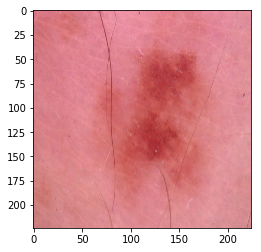

In [6]:
plt.imshow(X_orig[1])

In [7]:
# Load labels

Y_df = pd.read_csv('../ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv')

In [8]:
Y_df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
Y_orig = np.array(Y_df.iloc[:bs, 1:])

In [10]:
Y_orig.shape

(10015, 7)

In [11]:
labels = Y_df.iloc[:,1:].idxmax(axis = 1)

In [12]:
labels.head()

0     NV
1     NV
2     NV
3     NV
4    MEL
dtype: object

In [13]:
nonnv_index = Y_df['NV'] == 0
Y_df_nonnv = Y_df[nonnv_index].drop('NV', axis = 1)
Y_df_nonnv = Y_df_nonnv.reset_index(drop=True)
labels_nonnv = Y_df_nonnv.iloc[:,1:].idxmax(axis = 1)

Replace the labels with the following names of diseases:

* MEL: “Melanoma” diagnosis confidence
* NV: “Melanocytic nevus” diagnosis confidence
* BCC: “Basal cell carcinoma” diagnosis confidence
* AKIEC: “Actinic keratosis / Bowen’s disease (intraepithelial carcinoma)” diagnosis confidence
* BKL: “Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)” diagnosis confidence
* DF: “Dermatofibroma” diagnosis confidence
* VASC: “Vascular lesion” diagnosis confidence

In [14]:
labels.replace('MEL','Melanoma',inplace=True)
labels.replace('NV','Melanocytic nevus',inplace=True)
labels.replace('BCC','Basal cell carcinoma',inplace=True)
labels.replace('AKIEC','Actinic keratosis',inplace=True)
labels.replace('BKL','Benign keratosis',inplace=True)
labels.replace('DF','Dermatofibroma',inplace=True)
labels.replace('VASC','Vascular lesion',inplace=True)

In [15]:
labels_nonnv.replace('MEL','Melanoma',inplace=True)
labels_nonnv.replace('NV','Melanocytic nevus',inplace=True)
labels_nonnv.replace('BCC','Basal cell carcinoma',inplace=True)
labels_nonnv.replace('AKIEC','Actinic keratosis',inplace=True)
labels_nonnv.replace('BKL','Benign keratosis',inplace=True)
labels_nonnv.replace('DF','Dermatofibroma',inplace=True)
labels_nonnv.replace('VASC','Vascular lesion',inplace=True)

In [16]:
# Flip images and labels



In [17]:
X_orig_nonnv = X_orig[nonnv_index[:bs]]
m, n_H0, n_W0, n_C0 = X_orig_nonnv.shape
Y_orig_nonnv = np.array(Y_df_nonnv.iloc[:m, 1:])
X_orig_nonnv.shape, Y_orig_nonnv.shape

((3310, 224, 224, 3), (3310, 6))

ISIC_0024329


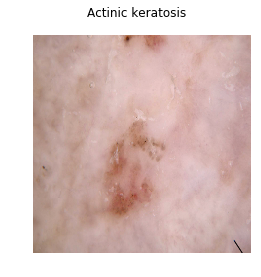

ISIC_0024330


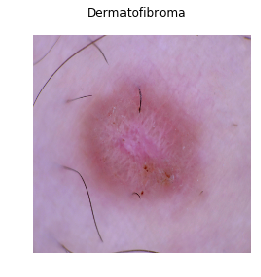

ISIC_0024331


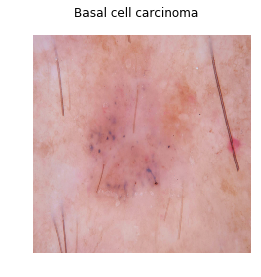

ISIC_0024332


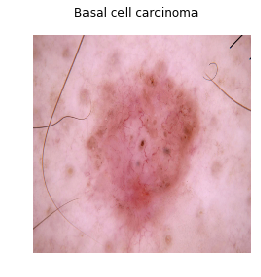

ISIC_0024333


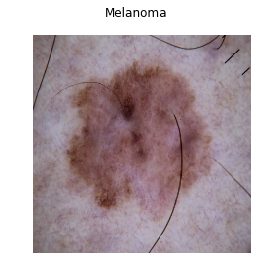

In [18]:
# Display images with labels

disp_num = 5
start_pos = 7

for i in range(start_pos,start_pos+disp_num):
    print(Y_df_nonnv.iloc[i,0])
    plt.imshow(X_orig_nonnv[i])
    plt.suptitle(labels_nonnv[i])
    plt.axis('off')
    plt.show()


In [19]:
X_flip_nonnv = X_orig_nonnv[:,:,n_W0-1::-1,:]
Y_flip_nonnv = Y_orig_nonnv

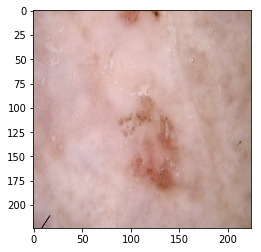

In [20]:
plt.imshow(X_flip_nonnv[start_pos])

In [21]:
Y_flip_nonnv.shape

(3310, 6)

In [22]:
# Make x and y training + dev arrays

train_size = 0.9

In [23]:
seed = 3
np.random.seed(seed)

In [24]:
X = np.vstack([X_orig_nonnv, X_flip_nonnv])
Y = np.vstack([Y_orig_nonnv, Y_flip_nonnv])

In [25]:
X.shape

(6620, 224, 224, 3)

In [26]:
Y.shape

(6620, 6)

In [27]:
train_index = np.random.choice(2*m, size = int(train_size*2*m), replace = False)
dev_index = list(set(range(2*m)) - set(train_index))

In [28]:
m_train = train_index.shape[0]

In [29]:
X_train = X[train_index]
Y_train = Y[train_index]

#X_train = np.empty([m_train, 224, 224, 3])
#Y_train = np.empty([m_train, 224, 224, 3])

#for i in train_index:
#    X_train[i] = X[i]
#    Y_train[i] = Y[i]
X_dev = X[dev_index]
Y_dev = Y[dev_index]

MemoryError: 

In [33]:
# ImageNet input image shape is (244, 244, 3)
inputs = tf.placeholder(tf.float32, [None, 224, 224, 3])

# Output is dependent on your situation (10 for CIFAR-10)
outputs = tf.placeholder(tf.float32, [None, 6])


# model to give the name
logits = nets.ResNet50(inputs, is_training=True, classes=6)
middles = logits.get_middles()

Z1 = tf.contrib.layers.flatten(middles[-1])
# FULLY-CONNECTED 
Z2 = tf.contrib.layers.fully_connected(Z1, 120)
# FULLY-CONNECTED 
Y_hat = tf.contrib.layers.fully_connected(Z2, 6, activation_fn = tf.nn.softmax)

# loss function applied to the last layer
# train on the loss (Adam Optimizer is used)
loss = tf.losses.softmax_cross_entropy(outputs, Y_hat)
train = tf.train.AdamOptimizer(learning_rate=1e-5).minimize(loss)

# for measuring accuracy after forward passing
predictions = tf.argmax(Y_hat, 1)
correct_pred = tf.equal(predictions, tf.argmax(outputs, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [43]:
batch_size = 32
num_epochs = 2
Y_train_preds = np.array([])
train_acc = 0
m_train = X_train.shape[0]
num_batches = (m_train//batch_size) + 1
train_acc = 0

In [44]:
with tf.Session() as sess:    
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Loading the parameters
    sess.run(logits.pretrained())
    
    for i in range(num_epochs):
        batch_loss = 0
        full_batch = range(m_train)
        for batch in range(num_batches):
            try:
                batch_index = np.random.choice(full_batch, size=batch_size, replace = False)
                full_batch = np.array(list(set(full_batch) - set(batch_index)))
            except ValueError:
                batch_index = full_batch
            X_train_batch = X_train[batch_index]
            Y_train_batch = Y_train[batch_index]
            sess.run(train, feed_dict = {inputs: X_train_batch, outputs: Y_train_batch})
            temp_loss = sess.run(loss, feed_dict ={inputs: X_train_batch, outputs: Y_train_batch})
            batch_loss += temp_loss/num_batches
    
    for batch in range(num_batches):
        try:
            batch_index = np.random.choice(full_batch, size=batch_size, replace = False)
            full_batch = np.array(list(set(full_batch) - set(batch_index)))
        except ValueError:
            batch_index = full_batch
        X_train_batch = X_train[batch_index]
        Y_train_batch = Y_train[batch_index]
        Y_batch_preds = sess.run(predictions, feed_dict = {inputs: X_train_batch})
        Y_train_preds = np.append(Y_train_preds, Y_batch_preds)
        temp_train_acc = sess.run(accuracy, feed_dict ={inputs: X_train_batch, outputs: Y_train_batch})*Y_train_batch.shape[0]
        train_acc += temp_train_acc/m_train
    
    Y_dev_preds = sess.run(predictions, feed_dict = {inputs: X_dev})
    dev_acc = sess.run(accuracy, feed_dict ={inputs: X_dev, outputs: Y_dev})

In [45]:
train_acc, dev_acc

(0.6666666818043545, 0.41269842)

In [ ]:
x = []